# 🛣️ Developing topic models from product text
In this notebook, I will find the underlying topics from products

I will be leveraging data from `.csv`

Data taken from : CPG distributor public site.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation as LDA
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

from data.etl import datafile_path_finder, find_nan, remove_newline_tabs_spaces
from model.nlp import top_features_sm, most_prevalent_topic, get_topic_words, topic_words_dist_ranked

# 1. Load the data

In [2]:
dir_df = datafile_path_finder('products.csv')
df = pd.read_csv(dir_df)
df = df[['HowTo']]

# 2. Validate the data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3743 entries, 0 to 3742
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   HowTo   2742 non-null   object
dtypes: object(1)
memory usage: 29.4+ KB


In [4]:
find_nan(df)

HowTo    1001
dtype: int64

# 3. Clean up the data

In [5]:
# Clean up the data
df = df.dropna()
df.shape

(2742, 1)

In [6]:
# Apply preprocessing function to the 'HowTo' column
df['HowTo'] = df['HowTo'].apply(remove_newline_tabs_spaces)

# 4. Create new features

BOW - Vectorization Menthod

In [7]:
# first run in pc install
# import nltk
# nltk.download('all')

stops = set(stopwords.words('english'))
#stops.add('xxxx')

In [8]:
vec = CountVectorizer(token_pattern= r'\b[a-zA-Z]{3,}\b',
                      stop_words=list(stops),
                      ngram_range= (1,2),
                      max_features=1000)

In [9]:
dtm = vec.fit_transform(df['HowTo'])

### Comprable Words Raking

In [10]:
top_features_sm(dtm, vec, 10)

{'hair': 4914,
 'apply': 2111,
 'rinse': 1717,
 'dry': 1469,
 'use': 1256,
 'shampoo': 1118,
 'minutes': 955,
 'scalp': 785,
 'damp': 755,
 'leave': 725}

# 6. Modeling

## LDA (Latent Dirichlet Allocation)
I will be using LDA method developed by David Blei. It is a generative probabilistic model that assumes documents are mixtures of topics, and topics are mixtures of words.

In [11]:
# build init model
topics = 30

lda = LDA(n_components= topics,
          doc_topic_prior = 25/topics,
          topic_word_prior = 0.15,
          n_jobs = -1,
          random_state =123
          )

doc_topics = lda.fit_transform(dtm)


### Inspect Model Output

In [12]:
# Validate the model

# should return the same number of the documents by the number of topics
doc_topics.shape

(2742, 30)

In [13]:
# should return 1 as the sum of the probabilities of the topics for each document (topic-relevance scores are probabalistic)
doc_topics.sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [14]:
# check the mean number of topics per document within a threshold
threshold = 0.1
dt2 = (doc_topics>threshold).astype(int)
dt2.sum(axis=1).mean()

1.4948942377826404

In [15]:
# define vocabulary and word distribution for each topic
vocab = np.array(vec.get_feature_names_out())
topic_lda_words = lda.components_
topic_lda_words.shape

(30, 1000)

In [16]:
# top words accross topics
vocab[topic_lda_words.sum(axis=0).argsort()[-10:]]

array(['leave', 'damp', 'scalp', 'minutes', 'shampoo', 'use', 'dry',
       'rinse', 'apply', 'hair'], dtype=object)

In [17]:
df['Most Prevalent Topic'] = most_prevalent_topic(doc_topics)
df.head()

,HowTo,Most Prevalent Topic
1,Massage It’s a 10 Miracle Coily Hydrating Sham...,4
2,• For best results use at least twice a week o...,22
3,1. After treating with Smoothing Mousse or Dam...,26
4,"Apply a generous amount to damp, freshly clean...",19
5,Cleanse the hair with INtech Pre-treatment Sha...,26


In [18]:
for topic_index in range(5):
    words = get_topic_words(topic_index, topic_lda_words, vocab, topn=10)
    print(f"Topic {topic_index}: {' | '.join(words)}")
    

Topic 0: dry | dry hair | hair | tip | texture | pro | pro tip | frizz | added | control
Topic 1: ends | roots | lengths | mid | volume | mid lengths | lengths ends | root | roots ends | conditioner
Topic 2: hair | curls | apply | curl | rinse | cleansing | thoroughly | rinse thoroughly | moisture | shampoo
Topic 3: spray | hold | shake | well | shake well | inches | hair | away | hair spray | inches away
Topic 4: dry | damp | blow | hair | blow dry | damp hair | styling | apply | hair blow | air


In [19]:
for doc_idx, topic_idx in enumerate(df['Most Prevalent Topic'].head()):
    print(f"Document {doc_idx}:")
    print(f"Most prevalent topic: Topic {topic_idx}")
    
    # Get the top words for the most prevalent topic
    top_words = topic_lda_words[topic_idx]
    top_words_indices = top_words.argsort()[-10:][::-1]  # Get indices of top 10 words
    top_words_list = [vocab[i] for i in top_words_indices]
    
    print(f"Top words for Topic {topic_idx}: {', '.join(top_words_list)}")
    print()

Document 0:
Most prevalent topic: Topic 4
Top words for Topic 4: dry, damp, blow, hair, blow dry, damp hair, styling, apply, hair blow, air

Document 1:
Most prevalent topic: Topic 22
Top words for Topic 22: wet hair, wet, lather, rinse, follow, conditioner, apply wet, lather rinse, hair, hair lather

Document 2:
Most prevalent topic: Topic 26
Top words for Topic 26: hair, dry, sections, brush, using, hair sections, smoothing, fine, medium, remove

Document 3:
Most prevalent topic: Topic 19
Top words for Topic 19: leave, minutes, leave minutes, minutes rinse, rinse, shampoo, treatment, apply, rinse thoroughly, hair leave

Document 4:
Most prevalent topic: Topic 26
Top words for Topic 26: hair, dry, sections, brush, using, hair sections, smoothing, fine, medium, remove



In [20]:
df['Top Words'] = df['Most Prevalent Topic'].apply(lambda topic_idx: ', '.join(topic_words_dist_ranked(topic_idx, topic_lda_words, vocab)))
df.head()

,HowTo,Most Prevalent Topic,Top Words
1,Massage It’s a 10 Miracle Coily Hydrating Sham...,4,"dry, damp, blow, hair, blow dry, damp hair, st..."
2,• For best results use at least twice a week o...,22,"wet hair, wet, lather, rinse, follow, conditio..."
3,1. After treating with Smoothing Mousse or Dam...,26,"hair, dry, sections, brush, using, hair sectio..."
4,"Apply a generous amount to damp, freshly clean...",19,"leave, minutes, leave minutes, minutes rinse, ..."
5,Cleanse the hair with INtech Pre-treatment Sha...,26,"hair, dry, sections, brush, using, hair sectio..."


###  LDA Tuning

In [21]:
records = []
for top in range(30,151,10):
    print(f"Fitting {top} topics")
    record = {'topics': top}
    
    lda = LDA(n_components= top,
          doc_topic_prior = 25/top,
          topic_word_prior = 0.15,
          n_jobs = -1,
          random_state =123
          )
    
    lda.fit(dtm)
    
    record['perplexity'] = lda.perplexity(dtm)
    umass = metric_coherence_gensim(measure= "u_mass",
                                    top_n=5,
                                    topic_word_distrib= lda.components_,
                                    dtm= dtm.todense(),
                                    vocab= vocab,
                                    texts= None                                    
                                    )
    record['mean_umass'] = np.mean(umass)
    records.append(record)
    
diagnostics = pd.DataFrame(records)
diagnostics

Fitting 30 topics
Fitting 40 topics
Fitting 50 topics
Fitting 60 topics
Fitting 70 topics
Fitting 80 topics
Fitting 90 topics
Fitting 100 topics
Fitting 110 topics
Fitting 120 topics
Fitting 130 topics
Fitting 140 topics
Fitting 150 topics


,topics,perplexity,mean_umass
0,30,395.833649,-1.505098
1,40,403.639067,-1.618340
2,50,438.852673,-1.944270
3,60,446.189362,-1.836636
4,70,456.397750,-2.457189
5,80,464.893215,-2.229196
6,90,478.256444,-2.420176
7,100,506.356631,-2.498438
8,110,508.031599,-2.430033
9,120,512.943687,-2.483714


### Plot performance metrics

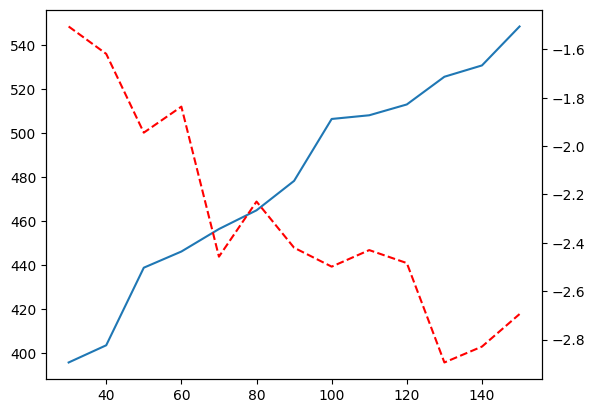

In [22]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(diagnostics['topics'], diagnostics['perplexity'])
ax2.plot(diagnostics['topics'], diagnostics['mean_umass'], color = 'red', linestyle='--')

Umass - higher better (more meaningful topics) based on words co-occur. Meaning 30 Topics are optimal.

## NMF (Non-Negative Matrix Factorization)
This method decomposes into two non-negative matrices: one representing documents in terms of topics and the other representing topics in terms of words.

Lets compare to results from other models such as NMF

In [23]:
nmf = NMF(n_components= 30, random_state=123)

doc_topics_nmf = nmf.fit_transform(dtm)
doc_topics_nmf.shape

(2742, 30)

### Inspect Model

In [24]:
# To transform to something that looks like LDA probabilities, or numbers summing to 1 by row
H = nmf.components_
dt2_h = (H /  H.sum(axis= 1)[:, None])
dt2_h.shape

(30, 1000)

In [25]:
# top words accross topics
vocab[dt2_h.sum(axis=0).argsort()[-10:]]

array(['desired', 'scalp', 'shampoo', 'minutes', 'dry', 'use', 'color',
       'rinse', 'apply', 'hair'], dtype=object)

In [26]:
df['Most Prevalent Topic NMF'] = most_prevalent_topic(doc_topics_nmf)
df.head()

,HowTo,Most Prevalent Topic,Top Words,Most Prevalent Topic NMF
1,Massage It’s a 10 Miracle Coily Hydrating Sham...,4,"dry, damp, blow, hair, blow dry, damp hair, st...",25
2,• For best results use at least twice a week o...,22,"wet hair, wet, lather, rinse, follow, conditio...",14
3,1. After treating with Smoothing Mousse or Dam...,26,"hair, dry, sections, brush, using, hair sectio...",0
4,"Apply a generous amount to damp, freshly clean...",19,"leave, minutes, leave minutes, minutes rinse, ...",19
5,Cleanse the hair with INtech Pre-treatment Sha...,26,"hair, dry, sections, brush, using, hair sectio...",0


In [27]:
for doc_idx, topic_idx in enumerate(df['Most Prevalent Topic NMF'].head()):
    print(f"Document {doc_idx}:")
    print(f"Most prevalent topic: Topic {topic_idx}")
    
    # Get the top words for the most prevalent topic
    top_words = dt2_h[topic_idx]
    top_words_indices = top_words.argsort()[-10:][::-1]  # Get indices of top 10 words
    top_words_list = [vocab[i] for i in top_words_indices]
    
    print(f"Top words for Topic {topic_idx}: {', '.join(top_words_list)}")
    print()

Document 0:
Most prevalent topic: Topic 25
Top words for Topic 25: product, contact, eyes, immediately, rinse, keep, skin, contact eyes, wrap, water

Document 1:
Most prevalent topic: Topic 14
Top words for Topic 14: wet, rinse, wet hair, lather, conditioner, massage, apply wet, follow, lather rinse, hair lather

Document 2:
Most prevalent topic: Topic 0
Top words for Topic 0: hair, product, dry hair, gently, natural, root, keratin, types, starting, throughout

Document 3:
Most prevalent topic: Topic 19
Top words for Topic 19: minutes, leave, rinse, minutes rinse, leave minutes, rinse thoroughly, thoroughly, hair leave, shampooing, mask

Document 4:
Most prevalent topic: Topic 0
Top words for Topic 0: hair, product, dry hair, gently, natural, root, keratin, types, starting, throughout



### NMF Tuning

In [28]:
records = []
for top in range(30,151,10):
    print(f"Fitting {top} topics")
    record = {'topics': top}
    lda = NMF(n_components= top, random_state=123, max_iter=1000,)
    
    lda.fit(dtm)
    
    #record['perplexity'] = lda.perplexity(dtm)
    umass = metric_coherence_gensim(measure= "u_mass",
                                    top_n=5,
                                    topic_word_distrib= lda.components_,
                                    dtm= dtm.todense(),
                                    vocab= vocab,
                                    texts= None                                    
                                    )
    record['mean_umass'] = np.mean(umass)
    records.append(record)
    
diagnostics = pd.DataFrame(records)
diagnostics

Fitting 30 topics
Fitting 40 topics
Fitting 50 topics
Fitting 60 topics
Fitting 70 topics
Fitting 80 topics
Fitting 90 topics
Fitting 100 topics
Fitting 110 topics
Fitting 120 topics
Fitting 130 topics
Fitting 140 topics
Fitting 150 topics


,topics,mean_umass
0,30,-1.681374
1,40,-1.842774
2,50,-2.074828
3,60,-1.932670
4,70,-2.190556
5,80,-2.491530
6,90,-2.414155
7,100,-2.457580
8,110,-2.646544
9,120,-2.586294


### Plot performance metrics

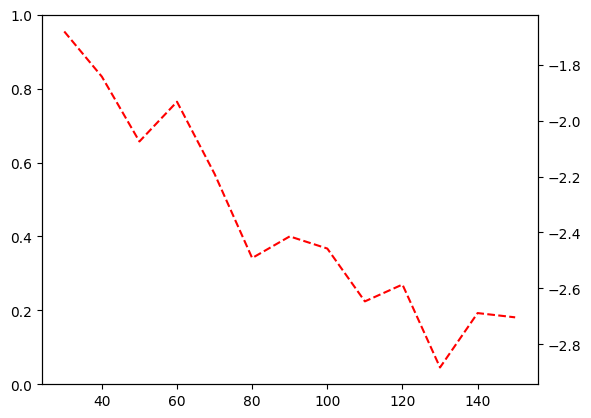

In [29]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax2.plot(diagnostics['topics'], diagnostics['mean_umass'], color = 'red', linestyle='--')

Umass - higher better (more meaningful topics) based on words co-occur. Meaning 30 Topics are optimal.

In [30]:
# Add top words for the most prevalent topic to DataFrame
df['Top Words NMF'] = df['Most Prevalent Topic NMF'].apply(lambda topic_idx: ', '.join(topic_words_dist_ranked(topic_idx, dt2_h, vocab)))
df.head()

,HowTo,Most Prevalent Topic,Top Words,Most Prevalent Topic NMF,Top Words NMF
1,Massage It’s a 10 Miracle Coily Hydrating Sham...,4,"dry, damp, blow, hair, blow dry, damp hair, st...",25,"product, contact, eyes, immediately, rinse, ke..."
2,• For best results use at least twice a week o...,22,"wet hair, wet, lather, rinse, follow, conditio...",14,"wet, rinse, wet hair, lather, conditioner, mas..."
3,1. After treating with Smoothing Mousse or Dam...,26,"hair, dry, sections, brush, using, hair sectio...",0,"hair, product, dry hair, gently, natural, root..."
4,"Apply a generous amount to damp, freshly clean...",19,"leave, minutes, leave minutes, minutes rinse, ...",19,"minutes, leave, rinse, minutes rinse, leave mi..."
5,Cleanse the hair with INtech Pre-treatment Sha...,26,"hair, dry, sections, brush, using, hair sectio...",0,"hair, product, dry hair, gently, natural, root..."


## LSA (Latent Semantic Analysis)
It is a dimensionality reduction technique that uses Singular Value Decomposition (SVD) to decompose the Document-Term Matrix into a set of latent topics.

In [31]:
lsa = TruncatedSVD(n_components=30)
# Fit and transform the TF-IDF matrix
doc_topics_lsa = lsa.fit_transform(dtm)
doc_topics_lsa.shape

(2742, 30)

### Inspect Model

In [32]:
# To transform to something that looks like LDA probabilities, or numbers summing to 1 by row
H = lsa.components_
H.shape

dt3_h = (H /  H.sum(axis= 1)[:, None])
dt3_h.shape

(30, 1000)

In [33]:
# top words accross topics
vocab[dt3_h.sum(axis=0).argsort()[-10:]]

array(['add drops', 'drops', 'style desired', 'rinse thoroughly',
       'thoroughly', 'style', 'shampoo', 'desired', 'damp hair', 'damp'],
      dtype=object)

In [34]:
df['Most Prevalent Topic LSA'] = most_prevalent_topic(doc_topics_lsa)
df.head()

,HowTo,Most Prevalent Topic,Top Words,Most Prevalent Topic NMF,Top Words NMF,Most Prevalent Topic LSA
1,Massage It’s a 10 Miracle Coily Hydrating Sham...,4,"dry, damp, blow, hair, blow dry, damp hair, st...",25,"product, contact, eyes, immediately, rinse, ke...",0
2,• For best results use at least twice a week o...,22,"wet hair, wet, lather, rinse, follow, conditio...",14,"wet, rinse, wet hair, lather, conditioner, mas...",0
3,1. After treating with Smoothing Mousse or Dam...,26,"hair, dry, sections, brush, using, hair sectio...",0,"hair, product, dry hair, gently, natural, root...",0
4,"Apply a generous amount to damp, freshly clean...",19,"leave, minutes, leave minutes, minutes rinse, ...",19,"minutes, leave, rinse, minutes rinse, leave mi...",0
5,Cleanse the hair with INtech Pre-treatment Sha...,26,"hair, dry, sections, brush, using, hair sectio...",0,"hair, product, dry hair, gently, natural, root...",0


### LSA Tuning

In [35]:
records = []
for top in range(30,151,10):
    print(f"Fitting {top} topics")
    record = {'topics': top}
    lsa = TruncatedSVD(n_components=top)
    
    lsa.fit(dtm)
    
    #record['perplexity'] = lda.perplexity(dtm)
    umass = metric_coherence_gensim(measure= "u_mass",
                                    top_n=5,
                                    topic_word_distrib= lsa.components_,
                                    dtm= dtm.todense(),
                                    vocab= vocab,
                                    texts= None                                    
                                    )
    record['mean_umass'] = np.mean(umass)
    records.append(record)
    
diagnostics = pd.DataFrame(records)
diagnostics

Fitting 30 topics
Fitting 40 topics
Fitting 50 topics
Fitting 60 topics
Fitting 70 topics
Fitting 80 topics
Fitting 90 topics
Fitting 100 topics
Fitting 110 topics
Fitting 120 topics
Fitting 130 topics
Fitting 140 topics
Fitting 150 topics


,topics,mean_umass
0,30,-1.983252
1,40,-2.279817
2,50,-2.377197
3,60,-2.612570
4,70,-2.977392
5,80,-2.883270
6,90,-3.060759
7,100,-3.168460
8,110,-3.397249
9,120,-3.479340


### Plot performance metrics

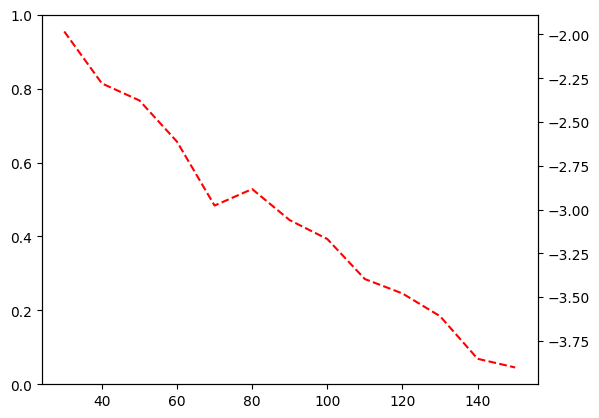

In [36]:
### Plot performance metrics
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax2.plot(diagnostics['topics'], diagnostics['mean_umass'], color = 'red', linestyle='--')

In [37]:
# Add top words for the most prevalent topic to DataFrame
df['Top Words LSA'] = df['Most Prevalent Topic LSA'].apply(lambda topic_idx: ', '.join(topic_words_dist_ranked(topic_idx, dt3_h, vocab)))
df.head()

,HowTo,Most Prevalent Topic,Top Words,Most Prevalent Topic NMF,Top Words NMF,Most Prevalent Topic LSA,Top Words LSA
1,Massage It’s a 10 Miracle Coily Hydrating Sham...,4,"dry, damp, blow, hair, blow dry, damp hair, st...",25,"product, contact, eyes, immediately, rinse, ke...",0,"hair, apply, rinse, dry, shampoo, use, minutes..."
2,• For best results use at least twice a week o...,22,"wet hair, wet, lather, rinse, follow, conditio...",14,"wet, rinse, wet hair, lather, conditioner, mas...",0,"hair, apply, rinse, dry, shampoo, use, minutes..."
3,1. After treating with Smoothing Mousse or Dam...,26,"hair, dry, sections, brush, using, hair sectio...",0,"hair, product, dry hair, gently, natural, root...",0,"hair, apply, rinse, dry, shampoo, use, minutes..."
4,"Apply a generous amount to damp, freshly clean...",19,"leave, minutes, leave minutes, minutes rinse, ...",19,"minutes, leave, rinse, minutes rinse, leave mi...",0,"hair, apply, rinse, dry, shampoo, use, minutes..."
5,Cleanse the hair with INtech Pre-treatment Sha...,26,"hair, dry, sections, brush, using, hair sectio...",0,"hair, product, dry hair, gently, natural, root...",0,"hair, apply, rinse, dry, shampoo, use, minutes..."


I did noticed that due to the vectorizer type the LSA values chanages, this might be due to the ties in BOW apporach. 

# 7. Conclusion

Based on the model the results of topics and words are different. This is not surprising as these methods are using different approaches under the hood.

Overall, I would prefer to go with the LDA method as is has been a well stablished methodn on this field.

From the results, I would use this to find related products that might fall well together based on their text description.